In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import argparse
import os

from line_profiler import LineProfiler
import pdb

In [2]:
time=[35]
models = ["GAM"]
taxas=["Mammals"]

In [19]:
#### Mammals and Amphibians #### 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:1]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                               
                            keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                            keys = list(set(keys))

                            num_codes = 0
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    num_codes += 1
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    
                                    da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                    da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]
                                    
                                    da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                    da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                    binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                    binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                    sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)
                                    
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    da_landuse["sum_lu_binary"] = sum_lu_binary
                                    da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                    da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                    
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    #da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

                            
                           # Create a new column with binary values (0 or 1) based on the condition if landuse[code] is greater than 0
        




In [6]:
####  birds #### 
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
taxas=["Bird"]


for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:1]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                               
                            keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                            keys = list(set(keys))

                            num_codes = 0
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    num_codes += 1
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    
                                    da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                    da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]
                                    
                                    da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                    da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                    binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                    binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                    sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)
                                    
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    da_landuse["sum_lu_binary"] = sum_lu_binary
                                    da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                    da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                    
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

                            
                         

In [3]:
#### birds hist ####


time=[1146]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {1146:2,35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 1146:
    model_names = ['EWEMBI']
    bioscen_model_names = ['EWEMBI']
       
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")

taxas=["Bird"]

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:

                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                results = []
                for i, species_name in enumerate(formatted_names[:1000]):
                    formatted_species_name = species_name.replace(" ", "_")

                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_model_name + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)
                    convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                    IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                    Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                    keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                    split_cols = Habitats['LUH'].str.split('.', expand=True)
                    for i, key in enumerate(keys):
                        if i < len(split_cols.columns):
                            Habitats[key] = split_cols[i]
                        else:
                            Habitats[key] = pd.Series(dtype='float64')
                    if len(Habitats.columns) > len(keys) + 1:
                        num_missing_cols = len(Habitats.columns) - len(keys) - 1
                        Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats.drop('LUH', axis=1, inplace=True)
                    Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                    LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc"

                    #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                    ncfname = LandUseList
                    da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                    da_landuse = da_landuse.isel(time=time)

                    #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                    df_sdm =df

                    #build an empty np.array 
                    np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                    #isimip_lats = isimip['lat'].values
                    #isimip_lons = isimip['lon'].values

                    lats = da_landuse['lat'].values
                    lons = da_landuse['lon'].values

                    da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                    da_landclim = da_empty.assign_attrs(da_landuse)

                    # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                    # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                    latitudes = df_sdm['lat'].unique()
                    longitudes = df_sdm['lon'].unique()

                    lats_sorted = np.sort(latitudes)
                    lons_sorted = np.sort(longitudes)

                   # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                    sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                    # Initialize the newvalue_array with NaNs instead of zeros
                    newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                    # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                    for i, lat in enumerate(lats_sorted):
                        for j, lon in enumerate(lons_sorted):
                            vals = sdm_dict.get((lat, lon), np.nan)
                            if not np.isnan(vals):
                                newvalue_array[i, j] = vals


                    da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                    # Interpolate the values of newvalue to the dimensions of A
                    interpolated_values = da.interp(lat=lats, lon=lons)

                    # Add the interpolated values to the A DataArray
                    da_landuse['newvalue'] = interpolated_values
                    da_landuse['newvalue'] = interpolated_values.fillna(0)


                    keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                    keys = list(set(keys))

                    num_codes = 0
                    for code in keys: 
                        # Check if the code is "MARINE" and skip land-use filter if it is
                        if code == "MARINE":
                            pass
                        else:
                            num_codes += 1
                            # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                            np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                            da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                            da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                            da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                            da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                            da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                            # Select the DataArrays ending in "_bin"
                            bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                            binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                            binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                            # Multiply all the arrays together
                            sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                            sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                            sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                            # Assign the "product_bin" attribute to the da_landuse DataArray
                            da_landuse["sum_bin"] = sum_bin
                            da_landuse["sum_lu_binary"] = sum_lu_binary
                            da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                            da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes

                            difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                            da_landuse["difference_filter"] = difference

                            da_landclim = da_landclim.assign_attrs(da_landuse)

In [4]:
IUCN

,Unnamed: 0,name,result.code,result.habitat,result.suitability,result.season,result.majorimportance
0,1,Phylloscopus goodsoni,1.6,Forest - Subtropical/Tropical Moist Lowland,Suitable,Breeding Season,No
1,2,Phylloscopus goodsoni,1.6,Forest - Subtropical/Tropical Moist Lowland,Suitable,Non-Breeding Season,No
2,3,Phylloscopus goodsoni,1.9,Forest - Subtropical/Tropical Moist Montane,Suitable,Breeding Season,No
3,4,Phylloscopus goodsoni,1.9,Forest - Subtropical/Tropical Moist Montane,Suitable,Non-Breeding Season,No


In [44]:
IUCN

,Unnamed: 0,name,result.code,result.habitat,result.suitability,result.season,result.majorimportance
0,1,Xenus cinereus,1.1,Forest - Boreal,Suitable,Breeding Season,No
1,2,Xenus cinereus,12.2,Marine Intertidal - Sandy Shoreline and/or Bea...,Suitable,Non-Breeding Season,Yes
2,3,Xenus cinereus,12.4,Marine Intertidal - Mud Flats and Salt Flats,Suitable,Non-Breeding Season,Yes
3,4,Xenus cinereus,13.4,Marine Coastal/Supratidal - Coastal Brackish/S...,Suitable,Non-Breeding Season,No
4,5,Xenus cinereus,13.5,Marine Coastal/Supratidal - Coastal Freshwater...,Suitable,Non-Breeding Season,No
5,6,Xenus cinereus,15.4,Artificial/Aquatic - Salt Exploitation Sites,Suitable,Non-Breeding Season,No
6,7,Xenus cinereus,1.7,Forest - Subtropical/Tropical Mangrove Vegetat...,Suitable,Non-Breeding Season,No
7,8,Xenus cinereus,3.1,Shrubland - Subarctic,Suitable,Breeding Season,No
8,9,Xenus cinereus,5.1,Wetlands (inland) - Permanent Rivers/Streams/C...,Suitable,Breeding Season,No
9,10,Xenus cinereus,5.10,Wetlands (inland) - Tundra Wetlands (incl. poo...,Suitable,Breeding Season,No


In [36]:
convcodes_renamed['result.code'] = convcodes_renamed['result.code'].astype(float)
convcodes_renamed

,result.code,LUH
0,1.10,primf.secdf
1,1.20,primf.secdf
2,1.30,primf.secdf
3,1.40,primf.secdf
4,1.50,primf.secdf
...,...,...
99,15.12,NaN
100,15.13,NaN
101,16.00,NaN
102,17.00,NaN


In [39]:
IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
print(IUCN)


    Unnamed: 0            name  result.code  \
0            1  Xenus cinereus          1.1   
1            2  Xenus cinereus         12.2   
2            3  Xenus cinereus         12.4   
3            4  Xenus cinereus         13.4   
4            5  Xenus cinereus         13.5   
5            6  Xenus cinereus         15.4   
6            7  Xenus cinereus          1.7   
7            8  Xenus cinereus          3.1   
8            9  Xenus cinereus          5.1   
9           10  Xenus cinereus          5.1   
10          11  Xenus cinereus          5.4   
11          12  Xenus cinereus          5.5   
12          13  Xenus cinereus          5.6   
13          14  Xenus cinereus          5.7   
14          15  Xenus cinereus          5.8   
15          16  Xenus cinereus          9.1   
16          17  Xenus cinereus          9.8   
17          18  Xenus cinereus          NaN   
18          19  Xenus cinereus          NaN   
19          20  Xenus cinereus          NaN   
20          2

In [40]:
 Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

In [41]:
Habitats

,Unnamed: 0,name,result.code,result.habitat,result.suitability,result.season,result.majorimportance,LUH
0,1,Xenus cinereus,1.1,Forest - Boreal,Suitable,Breeding Season,No,primf.secdf
1,2,Xenus cinereus,12.2,Marine Intertidal - Sandy Shoreline and/or Bea...,Suitable,Non-Breeding Season,Yes,primn.secdn
2,3,Xenus cinereus,12.4,Marine Intertidal - Mud Flats and Salt Flats,Suitable,Non-Breeding Season,Yes,primn.secdn
3,4,Xenus cinereus,13.4,Marine Coastal/Supratidal - Coastal Brackish/S...,Suitable,Non-Breeding Season,No,primn.secdn
4,5,Xenus cinereus,13.5,Marine Coastal/Supratidal - Coastal Freshwater...,Suitable,Non-Breeding Season,No,primn.secdn
5,6,Xenus cinereus,15.4,Artificial/Aquatic - Salt Exploitation Sites,Suitable,Non-Breeding Season,No,NaN
6,7,Xenus cinereus,1.7,Forest - Subtropical/Tropical Mangrove Vegetat...,Suitable,Non-Breeding Season,No,primf.secdf
7,8,Xenus cinereus,3.1,Shrubland - Subarctic,Suitable,Breeding Season,No,primn.secdn
8,9,Xenus cinereus,5.1,Wetlands (inland) - Permanent Rivers/Streams/C...,Suitable,Breeding Season,No,primn.secdn
9,9,Xenus cinereus,5.1,Wetlands (inland) - Permanent Rivers/Streams/C...,Suitable,Breeding Season,No,primn.secdn


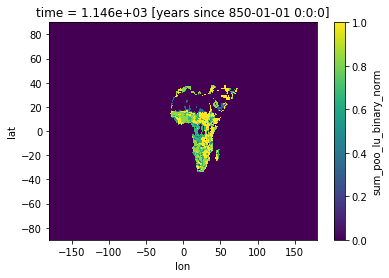

In [45]:
da_landuse["sum_poo_lu_binary_norm"].plot()


In [30]:
bioscen_species.head().to_markdown()


'|    |       x |      y |   GFDL-ESM2M_piControl_1845 |   HadGEM2-ES_piControl_1845 |   IPSL-CM5A-LR_piControl_1845 |   MIROC5_piControl_1845 |   GFDL-ESM2M_historical_1990 |   HadGEM2-ES_historical_1990 |   IPSL-CM5A-LR_historical_1990 |   MIROC5_historical_1990 |   EWEMBI_1995 |   GFDL-ESM2M_rcp26_2009 |   HadGEM2-ES_rcp26_2009 |   IPSL-CM5A-LR_rcp26_2009 |   MIROC5_rcp26_2009 |   GFDL-ESM2M_rcp60_2009 |   HadGEM2-ES_rcp60_2009 |   IPSL-CM5A-LR_rcp60_2009 |   MIROC5_rcp60_2009 |   GFDL-ESM2M_rcp26_2010 |   HadGEM2-ES_rcp26_2010 |   IPSL-CM5A-LR_rcp26_2010 |   MIROC5_rcp26_2010 |   GFDL-ESM2M_rcp60_2010 |   HadGEM2-ES_rcp60_2010 |   IPSL-CM5A-LR_rcp60_2010 |   MIROC5_rcp60_2010 |   GFDL-ESM2M_rcp26_2020 |   HadGEM2-ES_rcp26_2020 |   IPSL-CM5A-LR_rcp26_2020 |   MIROC5_rcp26_2020 |   GFDL-ESM2M_rcp60_2020 |   HadGEM2-ES_rcp60_2020 |   IPSL-CM5A-LR_rcp60_2020 |   MIROC5_rcp60_2020 |   GFDL-ESM2M_rcp26_2026 |   HadGEM2-ES_rcp26_2026 |   IPSL-CM5A-LR_rcp26_2026 |   MIROC5_rcp26_2026 |   G